## Project Statement

The goal of this project is to compare several unsupervised learning methods against a supervised method on a news classification task. The dataset was sourced from this kaggle contest (https://www.kaggle.com/competitions/learn-ai-bbc). It has news articles from the BBC that have been separated into 5 distinct categories: business, tech, politics, entertainment, and sport.

After performing some preprocessing on the articles, I will use TF-IDF vectorization to transform the articles into numerical representations. The number of features extracted in this process will be treated as a hyerparameter and I will examen the impact on model performance. 

For unsupervised learning, I will evaluate Non-Negative Matrix Factorization, Hierarchical Clustering, and K-Means Clustering by mapping their predicted clusters to the true categories and measuring accuracy. In this project, I will be using a Support Vector Machine classifier to make predicitions as the supervised method. To go beyond simple accuracy, confusion matrices will also be inspected to show how various models perform on this classication task.

# Basic EDA and Visualization

First and foremost, let's import all the required packages

In [1]:
import numpy as np
import pandas as pd
import os
#Visualization libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
#Tools for SVM Classifier, NMF, and clustering
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import NMF
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import permutations
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline
#NLP Libraries
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter


Let's load in the separate dataframes and take a look to see what we have.

In [2]:
train_df = pd.read_csv('data/BBC News Train.csv')
train_df.head(10)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment
8,2034,car giant hit by mercedes slump a slump in pro...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment


In [3]:
test_df = pd.read_csv('data/BBC News Test.csv')
test_df.head(10)

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
5,51,lewsey puzzle over disallowed try england s jo...
6,2025,blair blasts tory spending plans tony blair ha...
7,1479,former ni minister scott dies former northern ...
8,27,career honour for actor dicaprio actor leonard...
9,397,tsunami to hit sri lanka banks sri lanka s b...


In [4]:
submission_df = pd.read_csv('data/BBC News Sample Solution.csv')
submission_df.head(10)

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics
5,51,sport
6,2025,tech
7,1479,business
8,27,entertainment
9,397,politics


Okay so it looks like the submission file is an example of what our predictions for the test data should look, I'll ingore the categories as its impossible to know whether these are correct or not.

In [5]:
print('The train number of observations is ', train_df.shape[0])
print('The test number of observations is ', test_df.shape[0])
print('The total number of features for each observation is ', train_df.shape[1])
print('Percentage of null values per column: ', train_df.isnull().mean() * 100)
print('Number of duplicated texts in training: ', train_df.duplicated(subset=['Text'], keep=False).sum())

The train number of observations is  1490
The test number of observations is  735
The total number of features for each observation is  3
Percentage of null values per column:  ArticleId    0.0
Text         0.0
Category     0.0
dtype: float64
Number of duplicated texts in training:  100


Okay great so there is a training set of 1490 observations, a testing set of 735 observations. I listed the number of features as 3 but this is really just the number of rows in the dataframe. The only feature we will use here is the 'Text' column which is going to be expanded into matrices that will have the features representing the articles in this case. We won't have to worry about any missing values, but there are 100 duplicated texts in the training set that I will need to remove. Another thing I will need to do is encode the string categories into integers for the SVM Classifier. I'll do this using sklearn's label encoder and add this as a 4th feature instead of writing over the string categories.

In [6]:
train_df = train_df.drop_duplicates(subset=['Text'])
print('Number of duplicated texts in training: ', train_df.duplicated(subset=['Text'], keep=False).sum())
print('The train number of observations is ', train_df.shape[0])

Number of duplicated texts in training:  0
The train number of observations is  1440


So I removed all of the articles flagged as duplicates while keeping the first occurence.

In [7]:
label_encoder = LabelEncoder()
train_df['CategoryID'] = label_encoder.fit_transform(train_df['Category'])
train_df.head(10)

,ArticleId,Text,Category,CategoryID
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,4
4,917,enron bosses in $168m payout eighteen former e...,business,0
5,1582,howard truanted to play snooker conservative...,politics,2
6,651,wales silent on grand slam talk rhys williams ...,sport,3
7,1797,french honour for director parker british film...,entertainment,1
8,2034,car giant hit by mercedes slump a slump in pro...,business,0
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,1


CategoryID will be used to train our SVM model, let's save the mapping from the label encoder so we can use it to get back to categories later.

In [8]:
category_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(category_mapping)

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


Now let's take a look at the distribution of the different categories our labels in the training set.

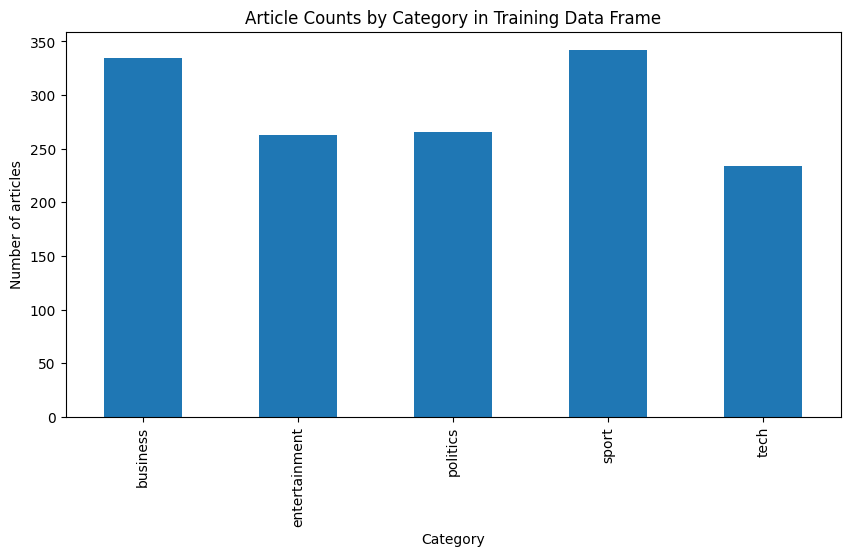

In [9]:
df_names = {'Training': train_df}
for name, df in df_names.items():
    counts = df.groupby('Category').size()
    plt.figure(figsize=(10,5))
    plot = counts.plot(kind='bar')
    plt.title(f'Article Counts by Category in {name} Data Frame')
    plt.xlabel('Category')
    plt.ylabel('Number of articles')

We can see a fairy even spread over the 5 categories which will be good for training our classifier. We could also take a look at the lengths of these texts.

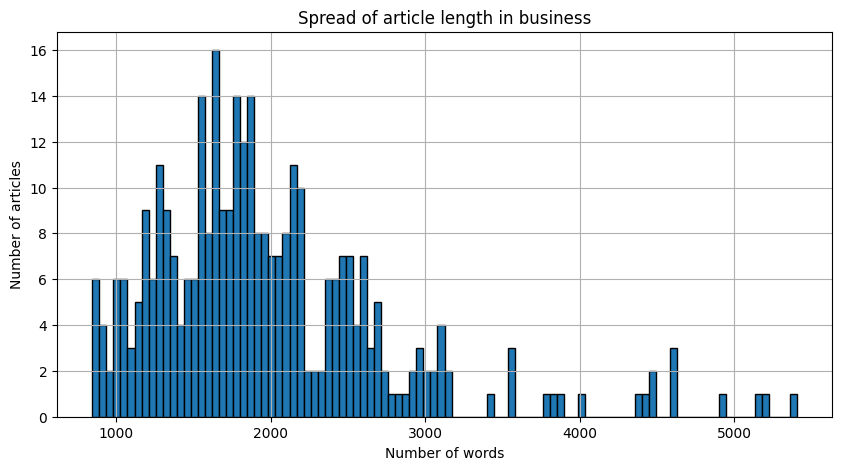

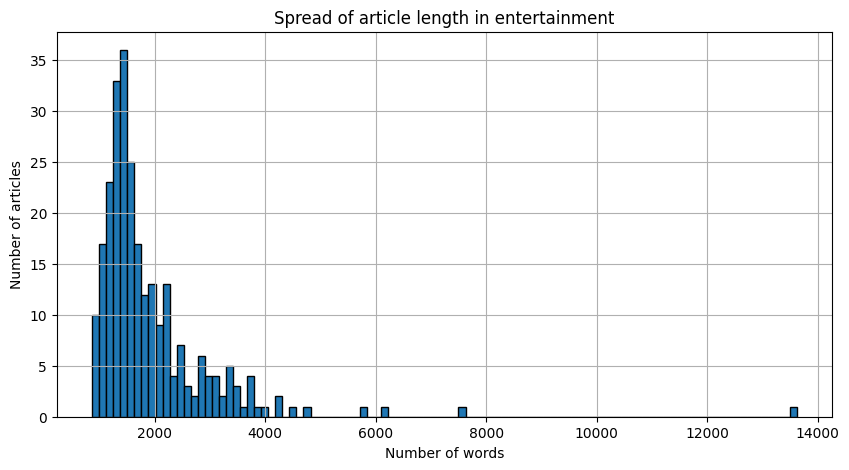

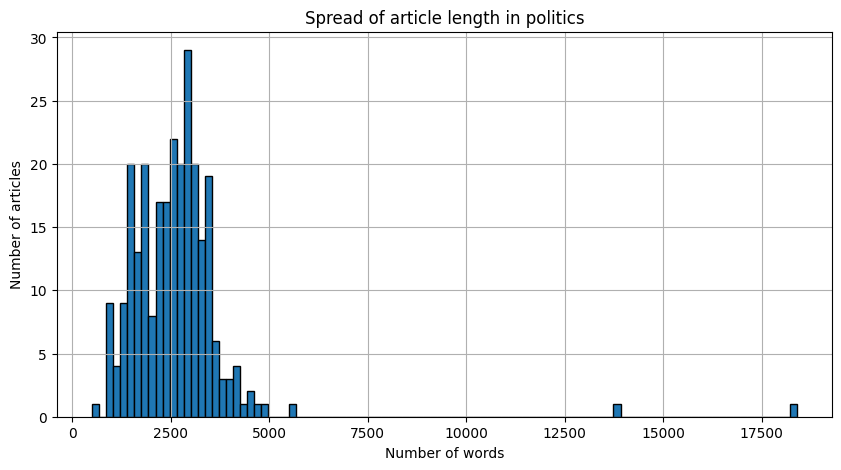

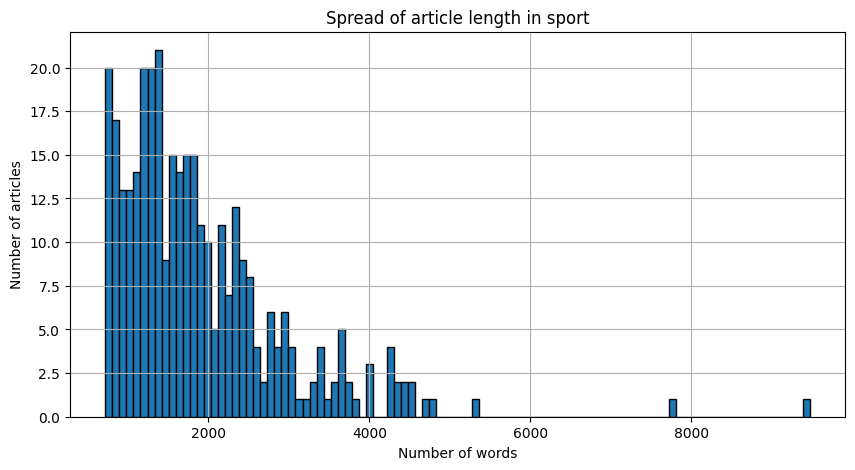

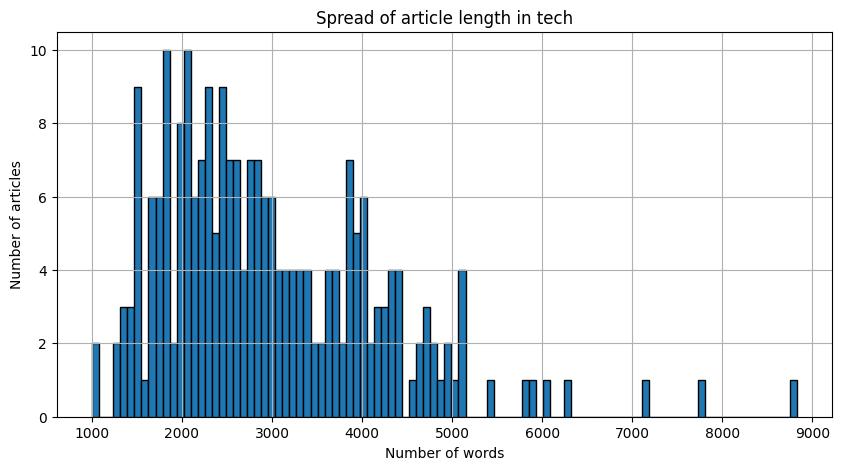

In [10]:
for category, num in category_mapping.items():
    filtered_df = train_df[train_df['Category'] == category]
    lengths = []
    for article in filtered_df['Text']:
        lengths.append(len(article))
    plt.figure(figsize=(10,5))
    plt.hist(lengths, bins=100, edgecolor='black')
    plt.title(f'Spread of article length in {category}')
    plt.xlabel('Number of words')
    plt.ylabel('Number of articles')
    plt.grid(True)

It looks like the average article length is about 2,500 characters and while almost all of the articles are less than 5,000 characters there are a few outliers with some having as many as 18,000 characters. I will not remove outliers for this analysis.

# Text Preprocessing

There are a few steps we are going to take to prepare these texts for evaluation with our models.
- Lowercasing: I am going to remove any capital letters ensuring words are treated the same (i.e. Article is the same as article).
- Tokenization: Turns sentencnes into lists of words so that each word can be processed individually.
- Stopword removal: I will remove extremely common words that have little semantic meaning such as 'the' and 'or'
- Lemmatization: I will convert all forms of a word to its root form so they will be treated the same (i.e. running becomes run)
- TF-IDF Vectorization: Converts articles into numerical representations which is required for non-negative matrix factorization. TF stands for term frequency and captures how often a word appears in an article. IDF stands for inverse document frequency and this will reduce the importance of words based off of how frequently they appear in all articles across the dataset. For more information on this topic follow the links at the end of the report.

Overall the preprocessing is going to imporve the topic separation achieved by NMF through removing noise and reducing word variation. I will show some text before and after the preprocessing to show how it will change things.

First let's create a function to take care of the preprocessing

In [11]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(article):
    tokens = word_tokenize(article.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stops]
    return " ".join(tokens)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Dan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


I'll apply the preprocessing to the training and testing data adding it as a new column.

In [12]:
train_df['preprocessed_text'] = train_df['Text'].apply(preprocess)
test_df['preprocessed_text'] = test_df['Text'].apply(preprocess)

Since I have removed common stopwords, this is a good time to look at the most frequent words in the different categories of news.

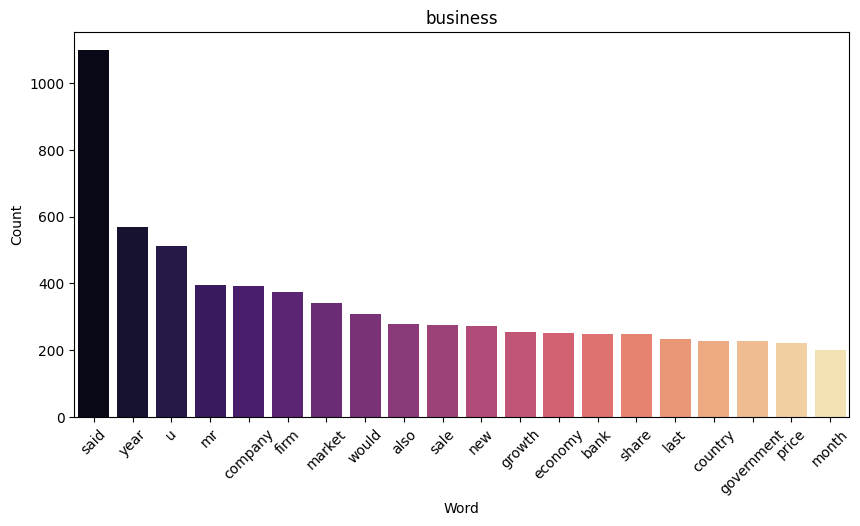

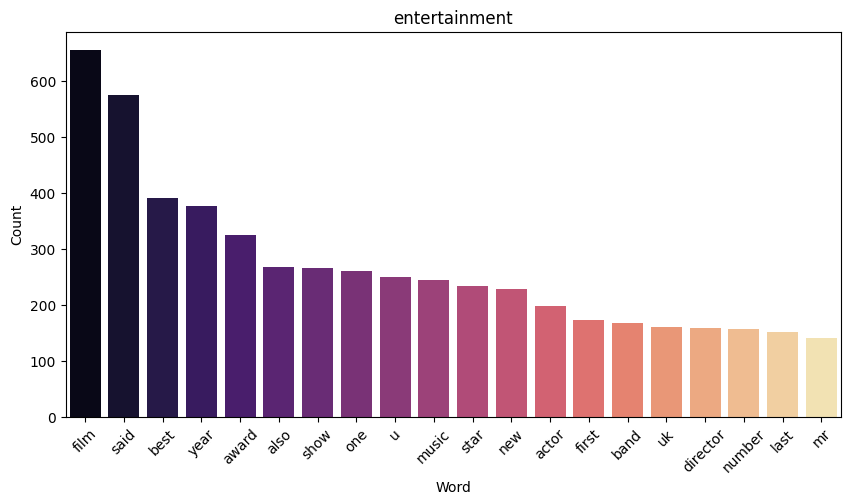

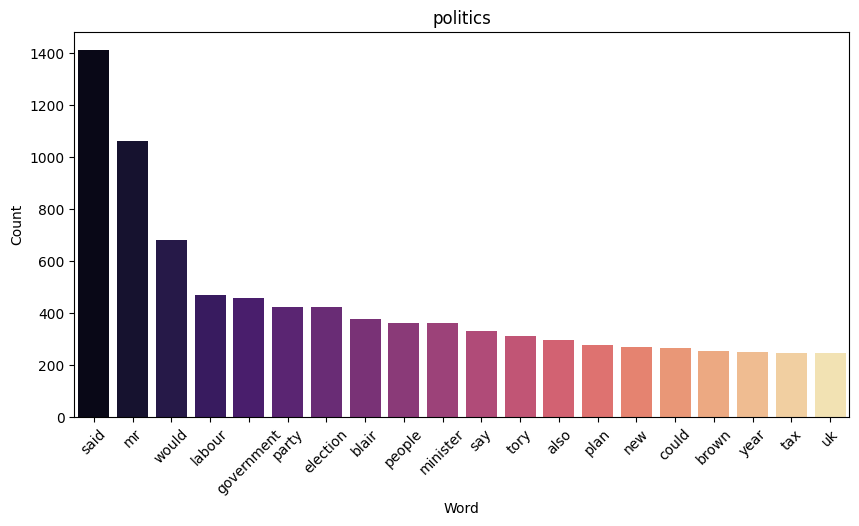

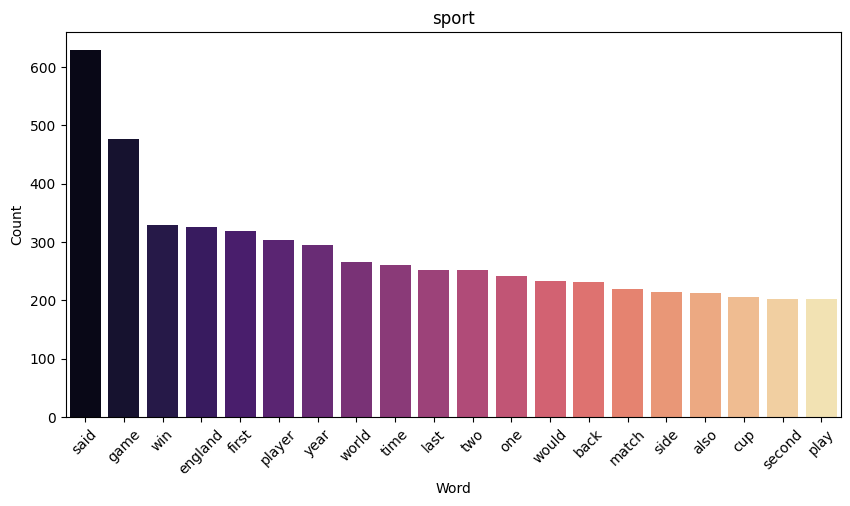

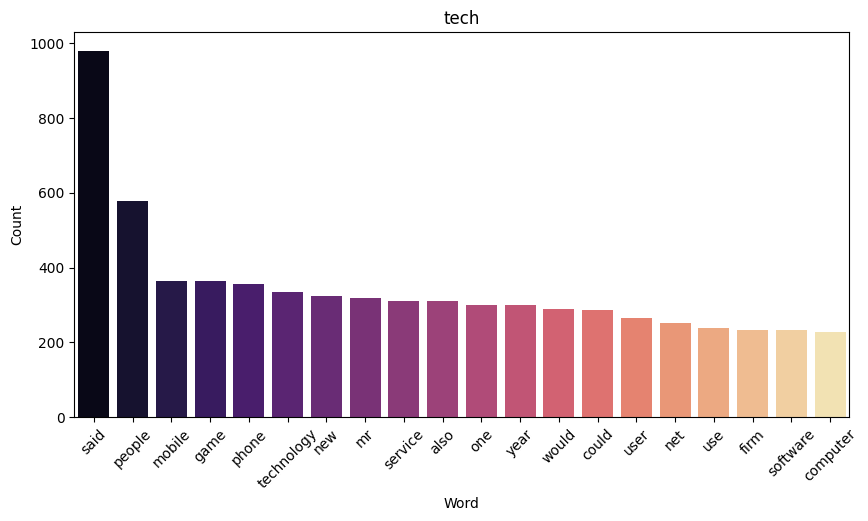

In [13]:
for category, num in category_mapping.items():
    filtered_df = train_df[train_df['Category'] == category]
    word_counts = Counter(' '.join(filtered_df['preprocessed_text']).split())
    common_words = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Count'])
    plt.figure(figsize=(10,5))
    sns.barplot(data=common_words, x='Word', y='Count', hue='Word', palette='magma', legend=False)
    plt.xticks(rotation=45)
    plt.title(f'{category}')
    plt.xlabel('Word')
    plt.ylabel('Count')

A few notes from each category:
- Business: Company, market, sale and growth are all related to business. Film is definitely more entertainment but a large source of revenue as well.
- Entertainment: Film, music, star, actor and band are all related to entertainment. Year could be related to any category.
- Sport: Game, win, match, player are replated to sports. First, world, time and last seem a little ambiguous.
- Tech: Mobile, phone, technology, user, net, software are all related to technology. New, film, and people could be other categories.

Overall, these frequent words make sense for their corresponding category. 

Things that could be improved:

- The word said is appearing in all articles very frequently which makes me think it should be a stop word, however the vectorization will lessen it's importance since it is a top word across all categories. Also mr and u are appearing frequently and aren't full words so they may need to be removed later.
- I'm not sure the lemmatization is fulling working, said could be turned into the root word say.
- U is likely coming from U.S.A being split into different tokens, this could be problematic.


Before I apply the vectorization let's take a look at an article to see how the preprocessing affects the text. Feel free to change the article index to inspect different articles.

In [14]:
article_index = 1
print('Here is an article before we perform the preprocessing')
print(train_df['Text'][article_index])

print('Here is the same article after the preprocessing')
print(train_df['preprocessed_text'][article_index])

Here is an article before we perform the preprocessing
german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy.  munich-based research institute ifo said that its confidence index fell to 95.5 in february from 97.5 in january  its first decline in three months. the study found that the outlook in both the manufacturing and retail sectors had worsened. observers had been hoping that a more confident business sector would signal that economic activity was picking up.   we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner.  the main reason is probably that the domestic economy is still weak  particularly in the retail trade.  economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline . he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest eco

# Building and Training Models

Now that I have completed the preprocessing, I am ready to start building models. The first thing to consider here is whether to use the complete data frame (training + testing w/ labels) or only the training data frame for the training set to our models. While using the complete data frame would likely increase the scores on the testing set, this would defeat the purpose of having a test set in the first place and I would not be able to test the generalizability of the model on examples not seen in the training set. Overfitting to the training data would likely occur if the test set was used in training. This phenomenon is often referred to as data leakage.

# Unsupervised Methods

I am going to look at three different unsupervised methods for performing classification of the news articles into the 5 categories. Non-negative matrix factorization (NMF) is a dimensionality reduction technique. The matrix of features will be decomposed into a 5x1 matrix where the 5 rows will represent the 5 categories. I will pick the largest value from this matrix and map it to one of the categories. Hierarchical clustering iteratively merges or splits clusters based on their similarity in the feature space until it reaches 5 clusters. K-Means clustering partitions the feature space into 5 clusters and adjusts the centroid of the clusters to minimize the variance between clusters. All of these methods require that the clusters be mapped to the categories of news, and this can be done by testing all permutations of the integer to category dictionary and evaluating the accuracy on the training set. With NMF, I can apply the verified mapping from the training set to the data in the test set and submit to the leaderboard on kaggle for accuracy on the test set. This will not be possible with K-means or Hierarchical clustering because they might require different mappings on the test set.

## Non-negative Matrix Factorization

Now I can apply the vectorization to the preprocessed text to get the train and testing sets. This will turn the tokens into vectors corresponding to the top 1000 words since I have set max_features to 1000.

In [15]:
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(train_df['preprocessed_text'])
X_test = vectorizer.transform(test_df['preprocessed_text'])

In [16]:
X_train.shape

(1440, 1000)

So for each article in the training set, there are 1000 features from the TF-IDF vectorization.

In [17]:
nmf = NMF(n_components=5, random_state=1)
NMF_train = nmf.fit_transform(X_train)
Y_pred_train = nmf.transform(X_train).argmax(axis=1)

In [18]:
mappings = list(permutations(category_mapping))


In [19]:
best_mapping = None
best_accuracy = 0
for mapping in mappings:
    #dictionary for our 5 categories
    category_to_int = {i: mapping[i] for i in range(5)}
    predicted_categories = np.array([category_to_int[i] for i in Y_pred_train])
    accuracy = accuracy_score(train_df['Category'], predicted_categories)

    #saving the best mapping
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_mapping = category_to_int

In [20]:
print('Best mapping: ', best_mapping)
print('Best accuracy: ', best_accuracy)

Best mapping:  {0: 'politics', 1: 'sport', 2: 'entertainment', 3: 'business', 4: 'tech'}
Best accuracy:  0.8909722222222223


Let's take a look at the correlation matrix now that I have the correct mapping. First I need to invert the best mapping and apply it to the Y_train_true.

Text(0.5, 1.0, 'Non-Negative Matrix Factorization')

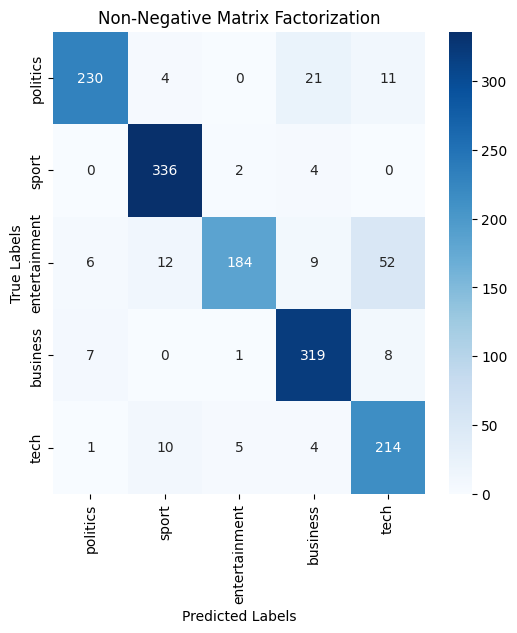

In [21]:
inverse_mapping = {v: k for k, v in best_mapping.items()}
cat_labels = list(best_mapping.values())
Y_train_true = np.array(train_df['Category'].map(inverse_mapping))
cm = confusion_matrix(Y_train_true, Y_pred_train)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cat_labels, yticklabels=cat_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Non-Negative Matrix Factorization')

Here are some observations on the confusion matrix:
- Overall this model is performing very well at the classification, the accuracy is 89%.
- The most misclassified category is entertainment and is frequently labeled tech by our model.
- Politics is often confused as business.
- Entertainment is often labeled sport.

Now that I have the correct mapping, I'll make predictions on the test set with the model, use the same mapping, and submit to the leaderboard for test accuracy results.

In [22]:
NMF_submission = nmf.transform(X_test).argmax(axis=1)

In [23]:
submission_df = submission_df.drop('Category', axis=1)
submission_df['Category'] = np.array([best_mapping[i] for i in NMF_submission]) 

In [24]:
submission_df.to_csv('Submission_NMF_2.csv', index=False)

This submission acheived an accuracy of 89.659% on the leaderboard. This is great because it appears that our model has not overfit to the training data.

One hyperparameter that we could try changing is the number of features we will get from our TF-IDF vectorization. For the baseline model we chose max features to be 1000. Let's try 10, 100, 500, 2000, 3000, and 4000 for our max features and then compare accuracy on the train and test sets.

In [25]:
maxfeatures = [10, 100, 500, 2000, 3000, 4000]
for maxfeature in maxfeatures:
    
    vectorizer = TfidfVectorizer(max_features=maxfeature)
    X_train = vectorizer.fit_transform(train_df['preprocessed_text'])
    X_test = vectorizer.transform(test_df['preprocessed_text'])
    nmf = NMF(n_components=5, random_state=1)
    NMF_train = nmf.fit_transform(X_train)
    Y_pred_train = nmf.transform(X_train).argmax(axis=1)
    mappings = list(permutations(category_mapping))
    best_mapping = None
    best_accuracy = 0
    for mapping in mappings:
        #dictionary for our 5 categories
        category_to_int = {i: mapping[i] for i in range(5)}
        predicted_categories = np.array([category_to_int[i] for i in Y_pred_train])
        accuracy = accuracy_score(train_df['Category'], predicted_categories)

        #saving the best mapping
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_mapping = category_to_int
    #print out accuracy on training set        
    print('Best mapping: ', best_mapping)
    print('Best accuracy: ', best_accuracy)
    #saving a submission on the test set to submit to leaderboard
    NMF_submission = nmf.transform(X_test).argmax(axis=1)
    submission_df = pd.read_csv('data/BBC News Sample Solution.csv')
    submission_df = submission_df.drop('Category', axis=1)
    submission_df['Category'] = np.array([best_mapping[i] for i in NMF_submission]) 
    submission_df.to_csv(f'Submission_NMF_{maxfeature}_features.csv', index=False)

Best mapping:  {0: 'business', 1: 'politics', 2: 'sport', 3: 'entertainment', 4: 'tech'}
Best accuracy:  0.4548611111111111
Best mapping:  {0: 'politics', 1: 'sport', 2: 'entertainment', 3: 'business', 4: 'tech'}
Best accuracy:  0.7166666666666667
Best mapping:  {0: 'politics', 1: 'sport', 2: 'entertainment', 3: 'business', 4: 'tech'}
Best accuracy:  0.8631944444444445
Best mapping:  {0: 'politics', 1: 'sport', 2: 'entertainment', 3: 'business', 4: 'tech'}
Best accuracy:  0.9
Best mapping:  {0: 'business', 1: 'politics', 2: 'entertainment', 3: 'sport', 4: 'tech'}
Best accuracy:  0.9
Best mapping:  {0: 'tech', 1: 'politics', 2: 'entertainment', 3: 'sport', 4: 'business'}
Best accuracy:  0.9020833333333333


# NMF Model Accuracy with Different Numbers of Features

| Max Features | Training Accuracy | Test Accuracy |
|-------------|------------------|--------------|
| 10          | 45.48%           | 42.18%       |
| 100         | 71.66%           | 69.25%       |
| 500         | 86.31%           | 86.53%       |
| 1000        | 89.10%           | 89.66%       |
| 2000        | 90.00%           | 90.88%       |
| 3000        | 90.00%           | 90.75%       |
| 4000        | 90.02%           | 89.93%       |3%       |

Observations from the table:
- It looks like 2000 will be the best number of features to have for this model since this is where we see the highest accuracy on the test set.
- Even though the training accuracy continues to get better with 3000, and 4000 features, the test accuracy does not increase which indicates that with more than 2000 features the model is beginning to overfit to the training data.

## Heirarchical and Kmeans Clustering

I am going to perform two types of clustering, Keamns and heirarchical, to cluster the training data into 5 categories. Then I'll figure out which clusters correspond to which category of news by testing the accuracy on the training set. I could do the same thing to the test data and submit to the leaderboard to compare with our other methods, but since there are 120 permutations of possible mappings I won't have enough time to test them all.

In [26]:
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(train_df['preprocessed_text'])
X_test = vectorizer.transform(test_df['preprocessed_text'])

In [27]:
hcluster = AgglomerativeClustering(n_clusters=5, linkage='ward')

In [28]:
hcluster_model = hcluster.fit(X_train.toarray())
Y_pred_train = hcluster_model.labels_
best_mapping = None
best_accuracy = 0
for mapping in mappings:
    #dictionary for our 5 categories
    category_to_int = {i: mapping[i] for i in range(5)}
    predicted_categories = np.array([category_to_int[i] for i in Y_pred_train])
    accuracy = accuracy_score(train_df['Category'], predicted_categories)

    #saving the best mapping
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_mapping = category_to_int
print('Best mapping: ', best_mapping)
print('Best accuracy: ', best_accuracy)

Best mapping:  {0: 'tech', 1: 'politics', 2: 'entertainment', 3: 'sport', 4: 'business'}
Best accuracy:  0.7888888888888889


Let's take a look at the confusion matrix

Text(0.5, 1.0, 'Hierarchical Clustering')

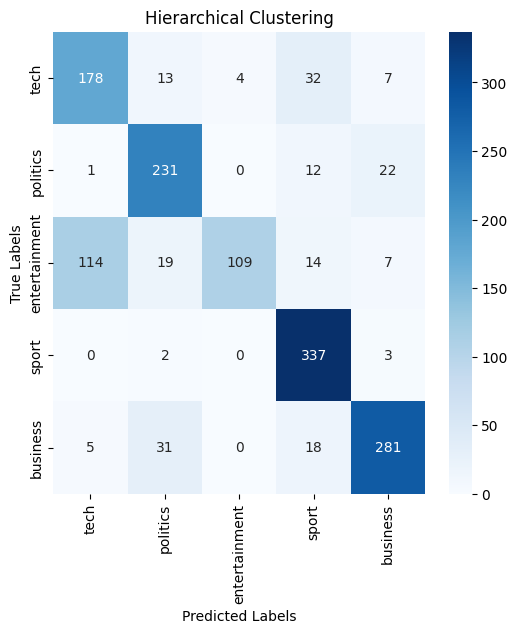

In [29]:
inverse_mapping = {v: k for k, v in best_mapping.items()}
cat_labels = list(best_mapping.values())
Y_train_true = np.array(train_df['Category'].map(inverse_mapping))
cm = confusion_matrix(Y_train_true, Y_pred_train)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cat_labels, yticklabels=cat_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Hierarchical Clustering')

Observations from the confusion matrix:
- The overall performace is a little worse than NMF model with 79% accuracy.
- The most commonly mislabeled category is entertainment being labeled as tech just like the NMF model.
- This model struggle with tech being labeled sport and business being labeled as poliltics which is different from the NMF model.

Testing different number of features on the training set

In [30]:
maxfeatures = [10, 100, 500, 2000, 3000, 4000]
for maxfeature in maxfeatures:    
    vectorizer = TfidfVectorizer(max_features=maxfeature)
    X_train = vectorizer.fit_transform(train_df['preprocessed_text'])
    hcluster_model = hcluster.fit(X_train.toarray())
    Y_pred_train = hcluster_model.labels_
    best_mapping = None
    best_accuracy = 0
    for mapping in mappings:
        #dictionary for our 5 categories
        category_to_int = {i: mapping[i] for i in range(5)}
        predicted_categories = np.array([category_to_int[i] for i in Y_pred_train])
        accuracy = accuracy_score(train_df['Category'], predicted_categories)

        #saving the best mapping
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_mapping = category_to_int
    print('Best mapping: ', best_mapping)
    print('Best accuracy: ', best_accuracy)

Best mapping:  {0: 'entertainment', 1: 'business', 2: 'politics', 3: 'sport', 4: 'tech'}
Best accuracy:  0.4375
Best mapping:  {0: 'tech', 1: 'entertainment', 2: 'sport', 3: 'politics', 4: 'business'}
Best accuracy:  0.5590277777777778
Best mapping:  {0: 'tech', 1: 'sport', 2: 'entertainment', 3: 'politics', 4: 'business'}
Best accuracy:  0.6597222222222222
Best mapping:  {0: 'tech', 1: 'sport', 2: 'politics', 3: 'entertainment', 4: 'business'}
Best accuracy:  0.7479166666666667
Best mapping:  {0: 'business', 1: 'sport', 2: 'entertainment', 3: 'politics', 4: 'tech'}
Best accuracy:  0.7208333333333333
Best mapping:  {0: 'business', 1: 'sport', 2: 'entertainment', 3: 'politics', 4: 'tech'}
Best accuracy:  0.7236111111111111


# Hierarchical Clustering Model Accuracy with Different Numbers of Features

| Max Features | Training Accuracy |
|-------------|------------------|
| 10          | 43.75%           |
| 100         | 55.90%           |
| 500         | 65.97%           |
| 1000        | 78.89%           |
| 2000        | 74.79%           |
| 3000        | 72.08%           |
| 4000        | 72.36%           |

Observations from the table:
- Accuracy increases with number of features up to 78% accuracy at 1000 features
- The model doesn't benefit from more than 1000 features and the accuracy decreases slightly.

In [31]:
kcluster = KMeans(n_clusters=5, random_state=1)

In [32]:
kcluster_model = kcluster.fit(X_train.toarray())
Y_pred_train = kcluster_model.labels_
best_mapping = None
best_accuracy = 0
for mapping in mappings:
    #dictionary for our 5 categories
    category_to_int = {i: mapping[i] for i in range(5)}
    predicted_categories = np.array([category_to_int[i] for i in Y_pred_train])
    accuracy = accuracy_score(train_df['Category'], predicted_categories)

    #saving the best mapping
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_mapping = category_to_int
print('Best mapping: ', best_mapping)
print('Best accuracy: ', best_accuracy)

C:\Users\Dan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best mapping:  {0: 'business', 1: 'entertainment', 2: 'sport', 3: 'politics', 4: 'tech'}
Best accuracy:  0.8444444444444444


Let's take a look at the confusion matrix

Text(45.72222222222221, 0.5, 'True Labels')

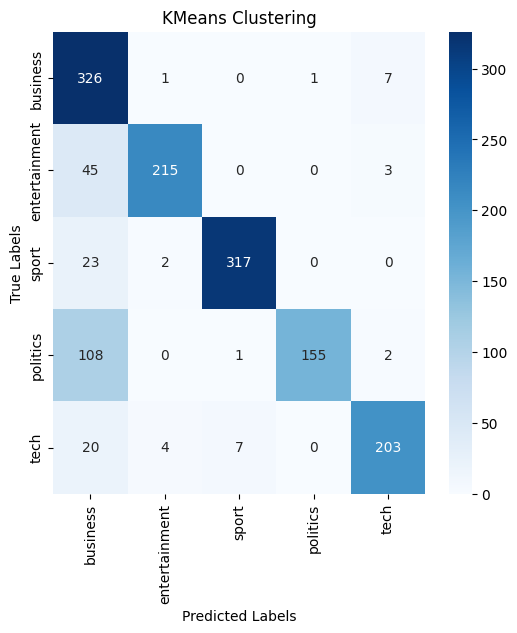

In [33]:
inverse_mapping = {v: k for k, v in best_mapping.items()}
cat_labels = list(best_mapping.values())
Y_train_true = np.array(train_df['Category'].map(inverse_mapping))
cm = confusion_matrix(Y_train_true, Y_pred_train)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cat_labels, yticklabels=cat_labels)
plt.title('KMeans Clustering')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

Observations from the confusion matrix:
- This model performs better than heirarchical clustering overall (84% compared to 79% accuracy).
- It struggles with classyfing business articles more than any other category. Both clustering methods show this pattern but it is most pronounced with Kmeans
- It most often classifies business articles as politics, followed by entertainment.

Testing different number of features

In [34]:
maxfeatures = [10, 100, 500, 2000, 3000, 4000]
for maxfeature in maxfeatures:    
    vectorizer = TfidfVectorizer(max_features=maxfeature)
    X_train = vectorizer.fit_transform(train_df['preprocessed_text'])
    kcluster_model = kcluster.fit(X_train.toarray())
    Y_pred_train = kcluster_model.labels_
    best_mapping = None
    best_accuracy = 0
    for mapping in mappings:
        #dictionary for our 5 categories
        category_to_int = {i: mapping[i] for i in range(5)}
        predicted_categories = np.array([category_to_int[i] for i in Y_pred_train])
        accuracy = accuracy_score(train_df['Category'], predicted_categories)

        #saving the best mapping
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_mapping = category_to_int
    print('Best mapping: ', best_mapping)
    print('Best accuracy: ', best_accuracy)

C:\Users\Dan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best mapping:  {0: 'tech', 1: 'entertainment', 2: 'business', 3: 'politics', 4: 'sport'}
Best accuracy:  0.43333333333333335


C:\Users\Dan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best mapping:  {0: 'sport', 1: 'business', 2: 'tech', 3: 'entertainment', 4: 'politics'}
Best accuracy:  0.7423611111111111


C:\Users\Dan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best mapping:  {0: 'politics', 1: 'entertainment', 2: 'business', 3: 'sport', 4: 'tech'}
Best accuracy:  0.8347222222222223


C:\Users\Dan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best mapping:  {0: 'business', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'sport'}
Best accuracy:  0.8555555555555555


C:\Users\Dan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best mapping:  {0: 'sport', 1: 'business', 2: 'politics', 3: 'entertainment', 4: 'tech'}
Best accuracy:  0.8319444444444445


C:\Users\Dan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best mapping:  {0: 'business', 1: 'entertainment', 2: 'sport', 3: 'politics', 4: 'tech'}
Best accuracy:  0.8444444444444444


# K-Means Clustering Model Accuracy with Different Numbers of Features

| Max Features | Training Accuracy |
|-------------|------------------|
| 10          | 43.33%           |
| 100         | 74.24%           |
| 500         | 83.47%           |
| 1000        | 84.44%           |
| 2000        | 85.56%           |
| 3000        | 83.19%           |
| 4000        | 84.44%           |

Observations from the table:
- Accuracy quickly increases up to 500 features, and slowly increases up to 2000 features at 85% accuracy.
- 3000 and 4000 features do not increase this models classification ability any further.

# Comparison to Supervised Learning - Support Vector Machine

A support vector machine adjusts it's decision boundary to minimize the error in classifying training data using the features from the vectorization. Once the decision boundary is optimized, it will be used to classify the test data based on the same features.

Define a pipeline for testing SVM models

In [35]:
pipeline_baselineSVM = make_pipeline(SVC(kernel='rbf', C=1, gamma=1))

In [36]:
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(train_df['preprocessed_text'])
X_test = vectorizer.transform(test_df['preprocessed_text'])

In [37]:
pipeline_baselineSVM.fit(X_train, np.array(train_df['CategoryID']))

Pipeline(steps=[('svc', SVC(C=1, gamma=1))])

In [38]:
y_pred = pipeline_baselineSVM.predict(X_train)

In [39]:
accuracy = accuracy_score(train_df['Category'], label_encoder.inverse_transform(y_pred))
print('Baseline SVM training accuracy: ', accuracy)

Baseline SVM training accuracy:  1.0


Okay so the model is getting all the training data correct with 100% accuracy, a confusion matrix would show everything correctly classified. Let's see if it has overfit to our test data by submitting the test predictions to the leaderboard.

In [40]:
y_pred = pipeline_baselineSVM.predict(X_test)

In [41]:
submission_df = pd.read_csv('data/BBC News Sample Solution.csv')
submission_df = submission_df.drop('Category', axis=1)
submission_df['Category'] = label_encoder.inverse_transform(y_pred)
submission_df.to_csv('Submission_SVM_baseline.csv', index=False)

This submission acheived 97.687% on the test set so we haven't overfit too bad.

Let's try tuning the hyperparameter by testing the performance on various number of features as input to the model.

In [ ]:
maxfeatures = [10, 100, 500, 2000, 3000, 4000]
for maxfeature in maxfeatures:

    vectorizer = TfidfVectorizer(max_features=maxfeature)
    X_train = vectorizer.fit_transform(train_df['preprocessed_text'])
    X_test = vectorizer.transform(test_df['preprocessed_text'])
    pipeline_baselineSVM.fit(X_train, np.array(train_df['CategoryID']))
    y_pred_train = pipeline_baselineSVM.predict(X_train)
    accuracy = accuracy_score(train_df['Category'], label_encoder.inverse_transform(y_pred_train))
    
    #print out accuracy on training set
    print('SVM training accuracy: ', accuracy)
    
    #saving a submission on the test set to submit to leaderboard
    y_pred_test = pipeline_baselineSVM.predict(X_test)    
    submission_df = pd.read_csv('data/BBC News Sample Solution.csv')
    submission_df = submission_df.drop('Category', axis=1)
    submission_df['Category'] = label_encoder.inverse_transform(y_pred_test)
    submission_df.to_csv(f'Submission_SVM_{maxfeature}_features.csv', index=False)

SVM training accuracy:  0.5958333333333333
SVM training accuracy:  0.9791666666666666
SVM training accuracy:  1.0


# SVM Model Accuracy with Different Numbers of Features

| Max Features | Training Accuracy | Test Accuracy |
|-------------|------------------|--------------|
| 10          | 59.58%           | 55.10%       |
| 100         | 97.92%           | 89.80%       |
| 500         | 100.0%           | 96.33%       |
| 1000        | 100.0%           | 97.69%       |
| 2000        | 99.93%           | 98.38%       |
| 3000        | 100.0%           | 98.38%       |
| 4000        | 100.0%           | 98.23%       |

Observations from the table:
- With 100 features, the model is already correctly classifying all of the training data.
- Test accuracy continues to improve up to 2000 features.
- After 2000 features, the model begins to overfit because accuracy doesn't increase further.

# Conclusion

## Model Accuracy Comparison on Training Data

| Max Features | NMF Accuracy | Hierarchical Clustering Accuracy | K-Means Clustering Accuracy | SVM Accuracy |
|-------------|-------------|----------------------------------|----------------------------|--------------|
| 10          | 45.48%      | 43.75%                           | 43.33%                     | 59.58%       |
| 100         | 71.66%      | 55.90%                           | 74.24%                     | 97.92%       |
| 500         | 86.31%      | 65.97%                           | 83.47%                     | 100.0%       |
| 1000        | 89.10%      | 78.89%                           | 84.44%                     | 100.0%       |
| 2000        | 90.00%      | 74.79%                           | 85.56%                     | 99.93%       |
| 3000        | 90.00%      | 72.08%                           | 83.19%                     | 100.0%       |
| 4000        | 90.02%      | 72.36%                           | 84.44%                     | 100.0%       |

The supervised approach with a support vector machine is clearly the best at this classification task. Even with only 100 features it can almost perfectly classify the training data. It is surprising how well some of the unsupervised methods can perform on a classification task. NMF was the best of the unsupervised methods getting up to 90% accuracy with 2000, 3000, and 4000 features. The latent features captured in the decomposed 5x1 matrices correlate well with the news categories. K-Means cluster was next best reaching 84% accuracy with 1000, 2000, 3000, and 4000 features, but one big problem is the cluster representing business turned out way too big. We can see from the confusion matrix that it misclassifies a lot of articles as business. Hierarchical clustering came in last only getting up to 78% accuracy at 1000 features. Since the accuracy actually decreases with more than 1000 features, this model struggles with high dimensional data. The SVM model is more efficient as well because it takes less features to acheive the same accuracy as the NMF model. 

Here are some resources used for understanding TF-IDF vectorization:
- https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/
- https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency/